## Instruction

- To use the training script, change the data address.

- While training, it is also required to provide the WandB API key.


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import os
import json
import matplotlib.pyplot as plt
from unet_parts import DoubleConv, Down, Up, OutConv
import wandb


class ColorUNet(nn.Module):
    def __init__(self, num_colors, img_size, n_channels=1, n_classes=3, bilinear=True):
        super().__init__()
        self.img_size = img_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        spatial_dim_at_bottleneck = self.img_size // (2**4)
        
        self.color_embed = nn.Sequential(
            nn.Linear(num_colors, 256),
            nn.ReLU(),
            nn.Linear(256, (1024 // factor) * spatial_dim_at_bottleneck * spatial_dim_at_bottleneck),
            nn.ReLU()
        )

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        self.outc = OutConv(64, n_classes)


    def forward(self, x, color_onehot):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        b = x.shape[0]
        spatial_dim_at_bottleneck = self.img_size // (2**4)
        
        color_feat_flat = self.color_embed(color_onehot)
        
        color_feat = color_feat_flat.view(b, self.down4.maxpool_conv[1].double_conv[0].out_channels,
                                         spatial_dim_at_bottleneck, spatial_dim_at_bottleneck)

        color_feat = color_feat.to(x5.device)
        
        fused_x5 = x5 + color_feat

        x = self.up1(fused_x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        output = torch.sigmoid(logits)
        return output


class PolygonColorRealDataset(Dataset):
    def __init__(self, root_dir, img_size, color_names, transform=None):
        self.root_dir = root_dir
        self.img_size = img_size

        with open(os.path.join(root_dir, 'data.json'), 'r') as f:
            raw_data = json.load(f)

        self.data = [
            item for item in raw_data
            if 'input_polygon' in item and 'output_image' in item and 'colour' in item
        ]

        if not self.data:
            raise ValueError(f"No valid entries with expected keys found in data.json in {root_dir}.")

        self.input_dir = os.path.join(root_dir, 'inputs')
        self.output_dir = os.path.join(root_dir, 'outputs')
        self.transform = transform if transform else transforms.ToTensor()

        self.color_names = color_names
        self.color_to_idx = {name: i for i, name in enumerate(self.color_names)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_path = os.path.join(self.input_dir, entry['input_polygon'])
        output_path = os.path.join(self.output_dir, entry['output_image'])

        mask = Image.open(input_path).convert('L').resize((self.img_size, self.img_size))
        target = Image.open(output_path).convert('RGB').resize((self.img_size, self.img_size))

        mask_tensor = self.transform(mask)
        target_tensor = self.transform(target)

        color_idx = self.color_to_idx[entry['colour']]
        color_onehot = torch.nn.functional.one_hot(
            torch.tensor(color_idx), num_classes=len(self.color_names)
        ).float()

        return mask_tensor, color_onehot, target_tensor


config = {
    "img_size": 64,
    "batch_size": 16,
    "epochs": 1000,
    "learning_rate": 5e-4,
    "bilinear_upsampling": True,
    "foreground_weight": 5.0,
    "dataset_train_root": r"C:\Users\Atharva Bhattad\OneDrive\Desktop\Python\New\Ayna_project\dataset\dataset\training",
    "dataset_val_root": r"C:\Users\Atharva Bhattad\OneDrive\Desktop\Python\New\Ayna_project\dataset\dataset\validation",
    "model_name": "ColorUNet_Deeper",
    "optimizer": "Adam",
    "loss_function": "MSE_Weighted"
}


IMG_SIZE = config["img_size"]
BATCH_SIZE = config["batch_size"]
EPOCHS = config["epochs"]
LR = config["learning_rate"]
BILINEAR = config["bilinear_upsampling"]
FOREGROUND_WEIGHT = config["foreground_weight"] 

wandb.init(project="polygon-colorizer", config=config)
wandb.run.name = f"deeper_unet_lr{LR}_epochs{EPOCHS}_fw{FOREGROUND_WEIGHT}"



train_root = config["dataset_train_root"]
val_root   = config["dataset_val_root"]


def get_all_colours(*root_dirs):
    colours = set()
    for rd in root_dirs:
        json_path = os.path.join(rd, 'data.json')
        if not os.path.exists(json_path):
            print(f"Warning: data.json not found in {rd}. Skipping this directory for color scanning.")
            continue
        try:
            with open(json_path, 'r') as f:
                items = json.load(f)
            for item in items:
                if 'colour' in item:
                    colours.add(item['colour'])
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from {json_path}. Skipping.")
    return sorted(list(colours))

all_colours = get_all_colours(train_root, val_root)
print("All colours:", all_colours)
print("Number of all colours:", len(all_colours))


train_dataset = PolygonColorRealDataset(train_root, img_size=IMG_SIZE, color_names=all_colours)
val_dataset   = PolygonColorRealDataset(val_root,   img_size=IMG_SIZE, color_names=all_colours)

assert len(train_dataset.color_names) == len(all_colours), \
    f"Train split color_names mismatch! {len(train_dataset.color_names)} vs {len(all_colours)}"
assert len(val_dataset.color_names) == len(all_colours), \
    f"Validation split color_names mismatch! {len(val_dataset.color_names)} vs {len(all_colours)}"


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ColorUNet(num_colors=len(all_colours), img_size=IMG_SIZE, bilinear=BILINEAR).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

wandb.watch(model, log_freq=100) 

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for i, (mask, color, target) in enumerate(train_loader):
        mask, color, target = mask.to(device), color.to(device), target.to(device)

        pred = model(mask, color)

        pixel_loss = F.mse_loss(pred, target, reduction='none')
        weight_mask_expanded = (mask > 0.1).float().expand_as(pred)
        
        weights = weight_mask_expanded * FOREGROUND_WEIGHT + (1 - weight_mask_expanded) * 1.0
        
        weighted_pixel_loss = pixel_loss * weights
        loss = weighted_pixel_loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (i+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, Batch {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}")


    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}")

   
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for mask, color, target in val_loader:
            mask, color, target = mask.to(device), color.to(device), target.to(device)
            pred = model(mask, color)
            
            val_pixel_loss = F.mse_loss(pred, target, reduction='none')
            val_weight_mask_expanded = (mask > 0.1).float().expand_as(pred)
            val_weights = val_weight_mask_expanded * FOREGROUND_WEIGHT + (1 - val_weight_mask_expanded) * 1.0
            val_weighted_pixel_loss = val_pixel_loss * val_weights
            val_loss += val_weighted_pixel_loss.mean().item()
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss:.4f}")

    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "epoch": epoch + 1
    })

    if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
        if len(val_dataset) > 0:
            sample_mask, sample_color, sample_target = val_dataset[0]
            sample_pred = model(sample_mask.unsqueeze(0).to(device), sample_color.unsqueeze(0).to(device))
            sample_pred = sample_pred.squeeze(0).cpu().detach().numpy() 
            sample_mask = sample_mask.squeeze().cpu().numpy()
            sample_target = sample_target.permute(1, 2, 0).cpu().numpy()

           
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(sample_mask, cmap='gray')
            axs[0].set_title("Input Mask")
            axs[0].axis('off')

            axs[1].imshow(sample_target)
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            axs[2].imshow(sample_pred.transpose(1, 2, 0)) 
            axs[2].set_title("Prediction")
            axs[2].axis('off')
            
            plt.tight_layout()
            
            wandb.log({"predictions": wandb.Image(plt)}, step=epoch + 1)
            plt.close(fig) 
        else:
            print("Validation dataset is empty, cannot log sample predictions to WandB.")


torch.save(model.state_dict(), "model_100.pth")
print("Model saved to polygon_colorizer.pth")

wandb.finish() 

All colours: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Number of all colours: 8
Using device: cuda
Epoch 1/1000 - Train Loss: 1.0598
Epoch 1/1000 - Validation Loss: 1.1285
Epoch 2/1000 - Train Loss: 0.8157
Epoch 2/1000 - Validation Loss: 0.9927
Epoch 3/1000 - Train Loss: 0.7163
Epoch 3/1000 - Validation Loss: 0.8407
Epoch 4/1000 - Train Loss: 0.6595
Epoch 4/1000 - Validation Loss: 0.7191
Epoch 5/1000 - Train Loss: 0.6114
Epoch 5/1000 - Validation Loss: 0.6250
Epoch 6/1000 - Train Loss: 0.5622
Epoch 6/1000 - Validation Loss: 0.5692
Epoch 7/1000 - Train Loss: 0.5305
Epoch 7/1000 - Validation Loss: 0.5425
Epoch 8/1000 - Train Loss: 0.5092
Epoch 8/1000 - Validation Loss: 0.5423
Epoch 9/1000 - Train Loss: 0.4902
Epoch 9/1000 - Validation Loss: 0.4700
Epoch 10/1000 - Train Loss: 0.4593
Epoch 10/1000 - Validation Loss: 0.4406
Epoch 11/1000 - Train Loss: 0.4402
Epoch 11/1000 - Validation Loss: 0.4153
Epoch 12/1000 - Train Loss: 0.4288
Epoch 12/1000 - Validation 

epoch,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
train_loss,█▄▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1000
train_loss,0.00108
val_loss,0.00018


# **To use the trained model for prediction**

Found 8 colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Using device: cuda
Successfully loaded model weights from C:\Users\Atharva Bhattad\OneDrive\Desktop\Python\New\Ayna_project\model_1000.pth

Running inference for a single sample...


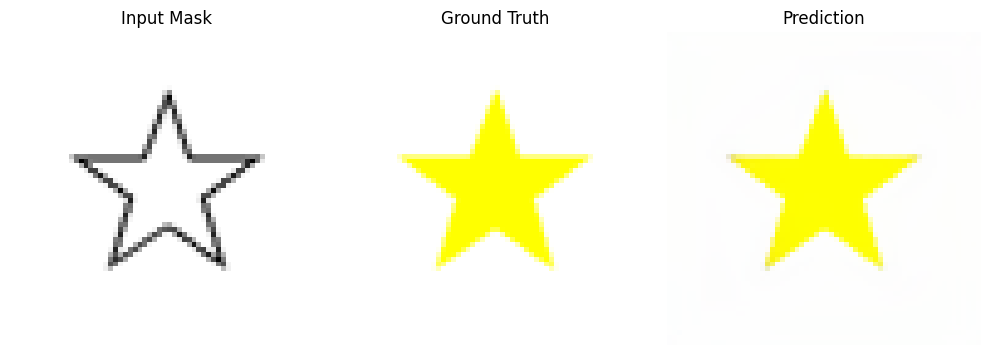

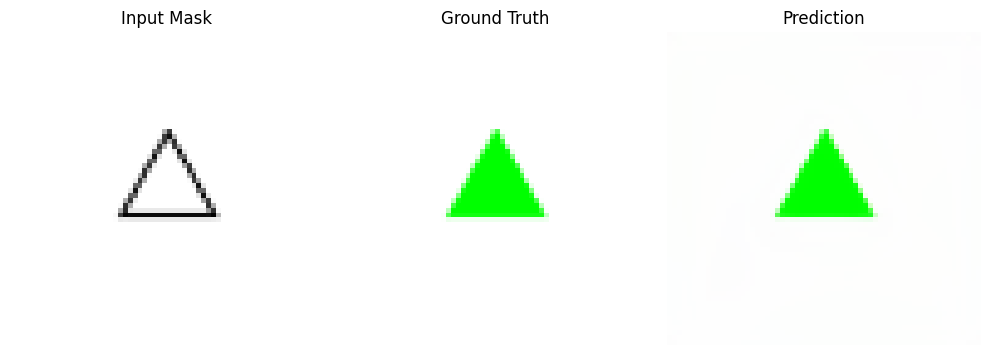

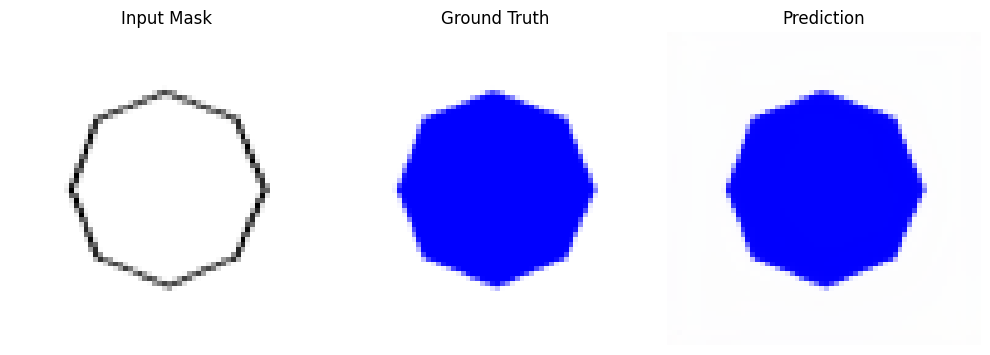

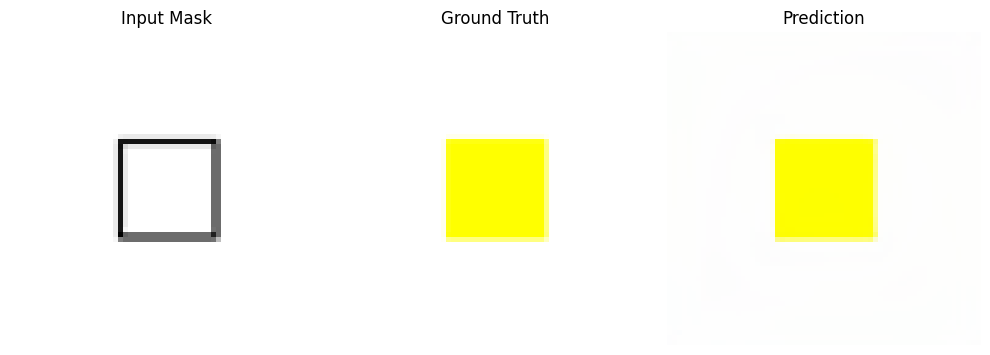

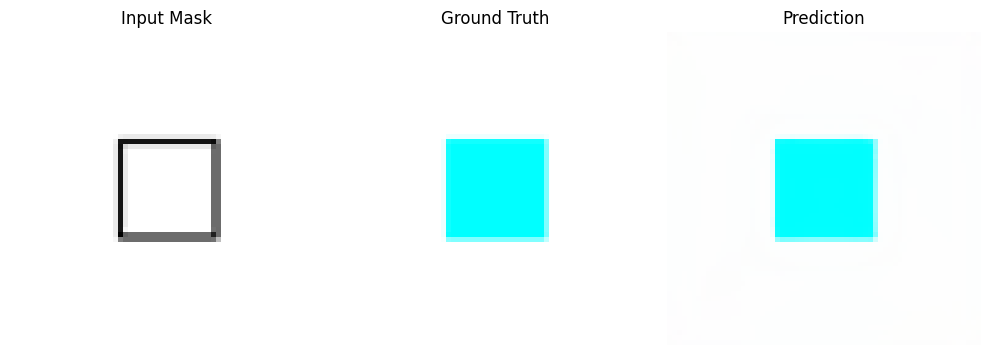


Running full validation loop to calculate average loss...
Average Weighted Validation Loss: 0.0002
Inference and validation complete.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import os
import json
import matplotlib.pyplot as plt

from unet_parts import DoubleConv, Down, Up, OutConv

class ColorUNet(nn.Module):
    def __init__(self, num_colors, img_size, n_channels=1, n_classes=3, bilinear=True):
        super().__init__()
        self.img_size = img_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        spatial_dim_at_bottleneck = self.img_size // (2**4)
        
        self.color_embed = nn.Sequential(
            nn.Linear(num_colors, 256),
            nn.ReLU(),
            nn.Linear(256, (1024 // factor) * spatial_dim_at_bottleneck * spatial_dim_at_bottleneck),
            nn.ReLU()
        )

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        self.outc = OutConv(64, n_classes)

    def forward(self, x, color_onehot):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        b = x.shape[0]
        spatial_dim_at_bottleneck = self.img_size // (2**4)
        
        color_feat_flat = self.color_embed(color_onehot)
        
        color_feat = color_feat_flat.view(b, self.down4.maxpool_conv[1].double_conv[0].out_channels,
                                         spatial_dim_at_bottleneck, spatial_dim_at_bottleneck)

        color_feat = color_feat.to(x5.device)
        
        fused_x5 = x5 + color_feat

        x = self.up1(fused_x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        output = torch.sigmoid(logits)
        return output


class PolygonColorRealDataset(Dataset):
    def __init__(self, root_dir, img_size, color_names, transform=None):
        self.root_dir = root_dir
        self.img_size = img_size

        with open(os.path.join(root_dir, 'data.json'), 'r') as f:
            raw_data = json.load(f)

        self.data = [
            item for item in raw_data
            if 'input_polygon' in item and 'output_image' in item and 'colour' in item
        ]

        if not self.data:
            raise ValueError(f"No valid entries with expected keys found in data.json in {root_dir}.")

        self.input_dir = os.path.join(root_dir, 'inputs')
        self.output_dir = os.path.join(root_dir, 'outputs')
        self.transform = transform if transform else transforms.ToTensor()

        self.color_names = color_names
        self.color_to_idx = {name: i for i, name in enumerate(self.color_names)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_path = os.path.join(self.input_dir, entry['input_polygon'])
        output_path = os.path.join(self.output_dir, entry['output_image'])

        mask = Image.open(input_path).convert('L').resize((self.img_size, self.img_size))
        target = Image.open(output_path).convert('RGB').resize((self.img_size, self.img_size))

        mask_tensor = self.transform(mask)
        target_tensor = self.transform(target)

        color_idx = self.color_to_idx[entry['colour']]
        color_onehot = torch.nn.functional.one_hot(
            torch.tensor(color_idx), num_classes=len(self.color_names)
        ).float()

        return mask_tensor, color_onehot, target_tensor


def get_all_colours(*root_dirs):
    colours = set()
    for rd in root_dirs:
        json_path = os.path.join(rd, 'data.json')
        if not os.path.exists(json_path):
            print(f"Warning: data.json not found in {rd}. Skipping this directory for color scanning.")
            continue
        try:
            with open(json_path, 'r') as f:
                items = json.load(f)
            for item in items:
                if 'colour' in item:
                    colours.add(item['colour'])
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from {json_path}. Skipping.")
    return sorted(list(colours))



if __name__ == "__main__":
    
    config = {
        "img_size": 64,
        "batch_size": 16,
        "epochs": 1000,
        "learning_rate": 5e-4,
        "bilinear_upsampling": True,
        "foreground_weight": 5.0,
        "dataset_train_root": r"C:\Users\Atharva Bhattad\OneDrive\Desktop\Python\New\Ayna_project\dataset\dataset\training",
        "dataset_val_root": r"C:\Users\Atharva Bhattad\OneDrive\Desktop\Python\New\Ayna_project\dataset\dataset\validation",
        "model_name": "ColorUNet_Deeper",
        "optimizer": "Adam",
        "loss_function": "MSE_Weighted"
    }

    IMG_SIZE = config["img_size"]
    BATCH_SIZE = config["batch_size"]
    BILINEAR = config["bilinear_upsampling"]

    
    val_root = config["dataset_val_root"]
    train_root = config["dataset_train_root"]
    all_colours = get_all_colours(train_root, val_root)
    print(f"Found {len(all_colours)} colors: {all_colours}")

  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    
    model = ColorUNet(
        num_colors=len(all_colours), 
        img_size=IMG_SIZE, 
        bilinear=BILINEAR
    ).to(device)

    try:
        model_path = r"C:\Users\Atharva Bhattad\OneDrive\Desktop\Python\New\Ayna_project\model_1000.pth"
        
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model weights from {model_path}")
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found. Please ensure it is in the correct directory.")
        exit()
    except RuntimeError as e:
        print(f"Error loading state_dict: {e}")
        print("This usually means the model architecture (e.g., class definition) does not match the saved weights.")
        exit()

    val_dataset = PolygonColorRealDataset(val_root, img_size=IMG_SIZE, color_names=all_colours)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    assert len(val_dataset.color_names) == len(all_colours), \
        f"Validation split color_names mismatch! {len(val_dataset.color_names)} vs {len(all_colours)}"


    model.eval()
    print("\nRunning inference for a single sample...")
    with torch.no_grad():
        if len(val_dataset) > 0:
            for i in range(len(val_dataset)):
                sample = val_dataset[i]
                mask, color, target = sample
                mask_input = mask.unsqueeze(0).to(device)
                color_input = color.unsqueeze(0).to(device)

                pred = model(mask_input, color_input)
                pred = pred.squeeze(0).cpu()

                pred_display = torch.clamp(pred, 0, 1)

                fig, axs = plt.subplots(1, 3, figsize=(10, 4))
                axs[0].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
                axs[0].set_title("Input Mask")
                axs[0].axis('off')

                axs[1].imshow(target.permute(1, 2, 0).cpu().numpy())
                axs[1].set_title("Ground Truth")
                axs[1].axis('off')


                axs[2].imshow(pred_display.permute(1, 2, 0).detach().numpy())
                axs[2].set_title("Prediction")
                axs[2].axis('off')

                plt.tight_layout()
                plt.show()
        else:
            print("Validation dataset is empty, cannot perform inference for local visualization.")


    print("\nRunning full validation loop to calculate average loss...")
    total_val_loss = 0
    with torch.no_grad():
        for mask_batch, color_batch, target_batch in val_loader:
            mask_batch, color_batch, target_batch = mask_batch.to(device), color_batch.to(device), target_batch.to(device)
            pred_batch = model(mask_batch, color_batch)
            pixel_loss = F.mse_loss(pred_batch, target_batch, reduction='none')
            weight_mask_expanded = (mask_batch > 0.1).float().expand_as(pred_batch)
            weights = weight_mask_expanded * config["foreground_weight"] + (1 - weight_mask_expanded) * 1.0
            weighted_pixel_loss = pixel_loss * weights
            total_val_loss += weighted_pixel_loss.mean().item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Average Weighted Validation Loss: {avg_val_loss:.4f}")
    print("Inference and validation complete.")